## Installing the Environment

In [ ]:
!pip uninstall torchtext -y # otherwise fails on PytorchLightning import
!pip install pytorch-lightning==1.2.10 omegaconf==2.0.6 albumentations==0.5.2 opencv-python-headless==4.5.4.58

Found existing installation: torchtext 0.11.0
Uninstalling torchtext-0.11.0:
  Successfully uninstalled torchtext-0.11.0
     |████████████████████████████████| 841 kB 11.4 MB/s 
     |████████████████████████████████| 72 kB 453 kB/s 
     |████████████████████████████████| 47.6 MB 113 kB/s 
     |████████████████████████████████| 596 kB 30.4 MB/s 
     |████████████████████████████████| 829 kB 31.5 MB/s 
     |████████████████████████████████| 176 kB 35.5 MB/s 
     |████████████████████████████████| 133 kB 38.6 MB/s 
     |████████████████████████████████| 948 kB 38.8 MB/s 
     |████████████████████████████████| 1.1 MB 40.1 MB/s 
     |████████████████████████████████| 144 kB 49.7 MB/s 
     |████████████████████████████████| 271 kB 50.9 MB/s 
     |████████████████████████████████| 94 kB 2.8 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=9eefacb53b33f19f08395b9f54a9f0259d0ba97cd445e3313956c16d668c4cb7
  Stored in directory: /root/.cache

In [ ]:
# Cloning the repo from GitHub
!git clone https://github.com/v-iashin/SpecVQGAN
%cd SpecVQGAN

Cloning into 'SpecVQGAN'...
remote: Enumerating objects: 396, done.
remote: Counting objects: 100% (396/396), done.
remote: Compressing objects: 100% (323/323), done.
remote: Total 396 (delta 68), reused 372 (delta 45), pack-reused 0
Receiving objects: 100% (396/396), 165.24 MiB | 20.82 MiB/s, done.
Resolving deltas: 100% (68/68), done.
Checking out files: 100% (231/231), done.
/content/SpecVQGAN


## Imports and Device Selection

In [ ]:
import os
from pathlib import Path
import soundfile
import torch
import IPython
import matplotlib.pyplot as plt


from feature_extraction.demo_utils import (calculate_codebook_bitrate,
                                           extract_melspectrogram,
                                           get_audio_file_bitrate,
                                           get_duration,
                                           load_neural_audio_codec)
from sample_visualization import tensor_to_plt
from torch.utils.data.dataloader import default_collate

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Select a Model
The model will be automatically downloaded given the `model_name`.


In [ ]:
model_name = '2021-05-19T22-16-54_vggsound_codebook'
log_dir = './logs'
# loading the models might take a few minutes
config, model, vocoder = load_neural_audio_codec(model_name, log_dir, device)

Using: 2021-05-19T22-16-54_vggsound_codebook (VGGSound Codebook)


881MB [01:30, 9.76MB/s]                           


Unpacking ./logs/2021-05-19T22-16-54_vggsound_codebook.tar.gz to ./logs
./logs/2021-05-19T22-16-54_vggsound_codebook/checkpoints/last.ckpt


1.65GB [02:42, 10.2MB/s]                            


loaded pretrained LPAPS loss from specvqgan/modules/autoencoder/lpaps/vggishish16.pt
VQLPAPSWithDiscriminator running with hinge loss.
Restored from ./logs/2021-05-19T22-16-54_vggsound_codebook/checkpoints/last.ckpt


## Select an Audio

The model was pre-trained on `(mels x time) = (80 x 848)`
spectrograms.
Considering the convolutional nature of the
Spectrogram VQGAN, it can also be applied to sounds of
a different duration.

In [ ]:
# Select an Audio
input_wav = './data/neural_audio_codec/music2/original.wav'

# Spectrogram Extraction
model_sr = config.data.params.sample_rate
duration = get_duration(input_wav)
spec = extract_melspectrogram(input_wav, sr=model_sr, duration=duration)
print(f'Audio Duration: {duration} seconds')
print('Original Spectrogram Shape:', spec.shape)

# Prepare Input
spectrogram = {'input': spec}
batch = default_collate([spectrogram])
batch['image'] = batch['input'].to(device)
x = model.get_input(batch, 'image')

using melspec_10s_22050hz
Audio Duration: 3.0 seconds
Original Spectrogram Shape: (80, 259)


## Encoding and Decoding

In [ ]:
with torch.no_grad():
    quant_z, diff, info = model.encode(x)
    xrec = model.decode(quant_z)

print('Compressed representation (it is all you need to recover the audio):')
F, T = quant_z.shape[-2:]
print(info[2].reshape(F, T))

Compressed representation (it is all you need to recover the audio):
tensor([[  43,  822,  916,   81,  164,  280,  322,  549,  651,  675,  523,  678,
          169,  250,   27, 1012],
        [  66,  792,  392,  838,  334,   61,    1,  545,  960,  173,  894,  228,
         1022, 1015,  202,  534],
        [ 669,  471,  659,  322,  619,  893,  813,  313,  685,  239,  707,  521,
          684,  215,   49,  810],
        [ 478,  771,  278,  500,  820,  941,  806,  980,  303,  383,  343,  788,
          979,  504,  547,  475],
        [ 163,  407,  709,  483,  611,  887,  111,  348,  456,  793,  538,   98,
          236,  986,  547,  350]], device='cuda:0')


## Displaying the Results

The input audio is 3.00 seconds long.
Codebook size is 1024 i.e. a codebook entry allocates 10 bits
SpecVQGAN bottleneck size: [5, 16]
Thus, bitrate is 0.26 kbps
Original audio (375 kbps):


Reconstructed audio (0.26 kbps):
Original Spectrogram:


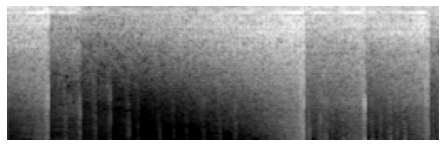

Reconstructed Spectrogram:


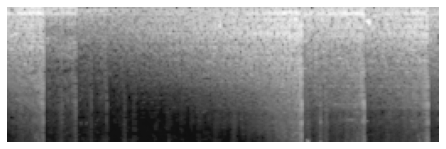

In [ ]:
# Calculate Bitrate
bitrate = calculate_codebook_bitrate(duration, quant_z, model.quantize.n_e)
orig_bitrate = get_audio_file_bitrate(input_wav)

# Save and Display
x = x.squeeze(0)
xrec = xrec.squeeze(0)
# specs are in [-1, 1], making them in [0, 1]
wav_x = vocoder((x + 1) / 2).squeeze().detach().cpu().numpy()
wav_xrec = vocoder((xrec + 1) / 2).squeeze().detach().cpu().numpy()
# Creating a temp folder which will hold the results
tmp_dir = os.path.join('./tmp/neural_audio_codec', Path(input_wav).parent.stem)
os.makedirs(tmp_dir, exist_ok=True)
# Save paths
x_save_path = Path(tmp_dir) / 'vocoded_orig_spec.wav'
xrec_save_path = Path(tmp_dir) / f'specvqgan_{bitrate:.2f}kbps.wav'
# Save
soundfile.write(x_save_path, wav_x, model_sr, 'PCM_16')
soundfile.write(xrec_save_path, wav_xrec, model_sr, 'PCM_16')
# Display
print(f'Original audio ({orig_bitrate:.0f} kbps):')
IPython.display.display(IPython.display.Audio(str(x_save_path)))
print(f'Reconstructed audio ({bitrate:.2f} kbps):')
IPython.display.display(IPython.display.Audio(str(xrec_save_path)))
print('Original Spectrogram:')
IPython.display.display(tensor_to_plt(x, flip_dims=(2,)))
plt.close()
print('Reconstructed Spectrogram:')
IPython.display.display(tensor_to_plt(xrec, flip_dims=(2,)))
plt.close()

In [ ]:
!echo "Versions of used packages"
!pip freeze

Versions of used packages
absl-py==1.0.0
aiohttp==3.8.1
aiosignal==1.2.0
alabaster==0.7.12
albumentations==0.5.2
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
async-timeout==4.0.2
asynctest==0.13.0
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.10
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.5.2
chardet==3.0.4
charset-normalizer==2.0.11
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda111==9.4.0
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.27
daft==0.0.4
dask==2.1